# Price Trend Analysis with Volatility Indicators using CoinAPI

## Introduction

This tutorial demonstrates how to perform advanced price trend analysis with volatility indicators using the CoinAPI Market Data REST API. Price trend analysis is essential for understanding market movements and making informed trading decisions. Volatility indicators help traders identify periods of high or low market activity, potential trend reversals, and optimal entry/exit points.

### What You Will Learn

- How to fetch historical exchange rate data from CoinAPI
- How to calculate various volatility indicators (ATR, normalized volatility)
- How to detect and analyze price trends
- How to create comprehensive visualizations
- How to perform statistical analysis of market patterns

### Prerequisites

- Python 3.7+
- CoinAPI API key (get one at https://www.coinapi.io/)
- Required packages: requests, pandas, numpy, matplotlib, seaborn

### API Setup

1. Go to https://www.coinapi.io/
2. Sign up for a free account
3. Get your API key from the dashboard
4. Replace `YOUR_COINAPI_KEY_HERE` in the code below with your actual API key

## 1. Environment Setup

First, let's set up our environment with the necessary imports and API configuration.

In [ ]:
# Import required libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, timezone
import json
from typing import Optional, List

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# CoinAPI configuration
API_KEY = "YOUR_COINAPI_KEY_HERE"  # Replace with your actual API key
BASE_URL = "https://rest.coinapi.io"

print("✅ Environment setup complete!")
print(f"📊 Using CoinAPI base URL: {BASE_URL}")
print(f"🔑 API Key configured: {'Yes' if API_KEY != 'YOUR_COINAPI_KEY_HERE' else 'No (Please update)'}")

✅ Environment setup complete!
📊 Using CoinAPI base URL: https://rest.coinapi.io
🔑 API Key configured: Yes


## 2. Data Fetching Function

We'll create a function to fetch historical exchange rate data from CoinAPI. This function will retrieve OHLC (Open, High, Low, Close) data which is perfect for calculating volatility indicators and analyzing price trends.

In [2]:
def fetch_exchange_rate_data(asset_id_base: str, asset_id_quote: str, period_id: str, time_start: str, time_end: str) -> Optional[List[dict]]:
    """
    Fetch historical exchange rate data from CoinAPI
    
    Args:
        asset_id_base: Base asset identifier (e.g., 'BTC')
        asset_id_quote: Quote asset identifier (e.g., 'USDT')
        period_id: Time period (e.g., '1HRS' for 1 hour)
        time_start: Start time in ISO format
        time_end: End time in ISO format
    
    Returns:
        List of exchange rate data points with OHLC data
    """
    url = f"{BASE_URL}/v1/exchangerate/{asset_id_base}/{asset_id_quote}/history"
    
    params = {
        'period_id': period_id,
        'time_start': time_start,
        'time_end': time_end,
        'limit': 10000
    }
    
    headers = {
        'X-CoinAPI-Key': API_KEY
    }
    
    try:
        print(f"🔄 Fetching data from {url}")
        print(f"📅 Time range: {time_start} to {time_end}")
        
        response = requests.get(url, params=params, headers=headers)
        response.raise_for_status()
        
        data = response.json()
        print(f"✅ Successfully fetched {len(data)} data points")
        return data
        
    except requests.exceptions.RequestException as e:
        print(f"❌ Error fetching data: {e}")
        if hasattr(e, 'response') and e.response is not None:
            print(f"Response status: {e.response.status_code}")
            print(f"Response text: {e.response.text}")
        return None

print("📋 Data fetching function created successfully!")

📋 Data fetching function created successfully!


## 3. Fetch Historical Data

Now let's fetch historical exchange rate data for BTC/USDT. We'll request data at a 1-hour interval for the past 7 days.

In [3]:
# Check if API key is configured
if API_KEY == "YOUR_COINAPI_KEY_HERE":
    print("❌ ERROR: Please set your CoinAPI key in the previous cell!")
    print("🔗 Get your API key at: https://www.coinapi.io/")
    print("📝 Replace 'YOUR_COINAPI_KEY_HERE' with your actual API key")
else:
    # Set up time range (last 7 days)
    end_time = datetime.now(timezone.utc)
    start_time = end_time - timedelta(days=7)
    
    # Format times for API
    time_start = start_time.strftime('%Y-%m-%dT%H:%M:%S')
    time_end = end_time.strftime('%Y-%m-%dT%H:%M:%S')
    
    # Fetch BTC/USDT data
    asset_id_base = "BTC"
    asset_id_quote = "USDT"
    period_id = "1HRS"
    
    print(f"🎯 Fetching {asset_id_base}/{asset_id_quote} data")
    print(f"⏱️  Period: {period_id}")
    
    exchange_rate_data = fetch_exchange_rate_data(asset_id_base, asset_id_quote, period_id, time_start, time_end)
    
    if exchange_rate_data:
        print("\n📊 Sample data structure:")
        print(json.dumps(exchange_rate_data[0], indent=2))
    else:
        print("\n❌ Failed to fetch data. Please check your API key and try again.")

🎯 Fetching BTC/USDT data
⏱️  Period: 1HRS
🔄 Fetching data from https://rest.coinapi.io/v1/exchangerate/BTC/USDT/history
📅 Time range: 2025-07-08T15:07:12 to 2025-07-15T15:07:12
✅ Successfully fetched 168 data points

📊 Sample data structure:
{
  "time_period_start": "2025-07-08T16:00:00.0000000Z",
  "time_period_end": "2025-07-08T17:00:00.0000000Z",
  "time_open": "2025-07-08T16:00:00.1000000Z",
  "time_close": "2025-07-08T16:59:59.9000000Z",
  "rate_open": 108273.16295175275,
  "rate_high": 108559.27205797151,
  "rate_low": 108089.54247934539,
  "rate_close": 108446.6117630905
}


## 4. Data Processing and Cleaning

Now let's convert the raw API data into a pandas DataFrame for easier analysis and perform some data cleaning.

In [4]:
if 'exchange_rate_data' in locals() and exchange_rate_data:
    # Convert to DataFrame
    df = pd.DataFrame(exchange_rate_data)
    
    print(f"📈 DataFrame created with shape: {df.shape}")
    print(f"📋 Columns: {list(df.columns)}")
    
    # Convert time columns to datetime
    df['time_period_start'] = pd.to_datetime(df['time_period_start'])
    df['time_period_end'] = pd.to_datetime(df['time_period_end'])
    
    # Rename columns for clarity
    df = df.rename(columns={
        'rate_open': 'open',
        'rate_high': 'high',
        'rate_low': 'low',
        'rate_close': 'close'
    })
    
    # Sort by time
    df = df.sort_values('time_period_start')
    
    print("\n📊 First few rows:")
    display(df.head())
    
    print("\n📋 Data types:")
    print(df.dtypes)
    
    print("\n📈 Summary statistics:")
    display(df[['open', 'high', 'low', 'close']].describe())
    
    # Check for missing values
    print("\n🔍 Missing values check:")
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print(missing_values[missing_values > 0])
    else:
        print("✅ No missing values found!")
        
else:
    print("❌ No data available for processing.")

📈 DataFrame created with shape: (168, 8)
📋 Columns: ['time_period_start', 'time_period_end', 'time_open', 'time_close', 'rate_open', 'rate_high', 'rate_low', 'rate_close']

📊 First few rows:


,time_period_start,time_period_end,time_open,time_close,open,high,low,close
0,2025-07-08 16:00:00+00:00,2025-07-08 17:00:00+00:00,2025-07-08T16:00:00.1000000Z,2025-07-08T16:59:59.9000000Z,108273.162952,108559.272058,108089.542479,108446.611763
1,2025-07-08 17:00:00+00:00,2025-07-08 18:00:00+00:00,2025-07-08T17:00:00.0000000Z,2025-07-08T17:59:59.9000000Z,108446.560951,109118.903087,108433.060883,108992.512505
2,2025-07-08 18:00:00+00:00,2025-07-08 19:00:00+00:00,2025-07-08T18:00:00.0000000Z,2025-07-08T18:59:59.8000000Z,108992.511813,109172.372158,108914.395031,109160.054626
3,2025-07-08 19:00:00+00:00,2025-07-08 20:00:00+00:00,2025-07-08T19:00:00.0000000Z,2025-07-08T19:59:59.9000000Z,109160.054626,109166.228089,108747.781101,108778.801776
4,2025-07-08 20:00:00+00:00,2025-07-08 21:00:00+00:00,2025-07-08T20:00:00.0000000Z,2025-07-08T20:59:59.9000000Z,108779.333043,108949.665184,108640.644820,108680.949952



📋 Data types:
time_period_start    datetime64[ns, UTC]
time_period_end      datetime64[ns, UTC]
time_open                         object
time_close                        object
open                             float64
high                             float64
low                              float64
close                            float64
dtype: object

📈 Summary statistics:


,open,high,low,close
count,168.000000,168.000000,168.000000,168.000000
mean,115701.871611,116019.444476,115414.747858,115748.644910
std,4110.960931,4130.685909,4030.008808,4069.899305
min,108273.162952,108559.272058,108089.542479,108375.914978
25%,111239.876258,111430.712077,111012.066202,111242.310857
50%,117485.272231,117663.490559,117195.364793,117485.272231
75%,118091.978431,118453.823024,117851.778283,118091.183057
max,122737.262279,123225.589450,122281.080900,122731.331256



🔍 Missing values check:
✅ No missing values found!


## 5. Volatility Indicators Calculation

Volatility indicators help us understand the magnitude of price movements and market activity. We'll calculate several volatility-based indicators from the data:

- **Price Range**: High - Low (absolute volatility)
- **Normalized Volatility**: (High - Low) / Close (relative volatility)
- **Average True Range (ATR)**: A more sophisticated volatility measure
- **Volatility Ratio**: Current volatility vs historical average
- **Moving Averages**: Simple moving averages for trend analysis

In [5]:
if 'df' in locals() and not df.empty:
    print("🔢 Calculating volatility indicators...")
    
    # Basic volatility indicators
    df['volatility'] = df['high'] - df['low']  # Price range
    df['normalized_volatility'] = (df['high'] - df['low']) / df['close']  # Relative volatility
    
    # Calculate True Range (TR) for ATR
    df['tr1'] = df['high'] - df['low']
    df['tr2'] = abs(df['high'] - df['close'].shift(1))
    df['tr3'] = abs(df['low'] - df['close'].shift(1))
    df['true_range'] = df[['tr1', 'tr2', 'tr3']].max(axis=1)
    
    # Calculate ATR (14-period average)
    df['atr'] = df['true_range'].rolling(window=14).mean()
    
    # Calculate volatility ratio (current vs historical average)
    df['volatility_ratio'] = df['normalized_volatility'] / df['normalized_volatility'].rolling(window=20).mean()
    
    # Calculate simple moving averages
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['sma_50'] = df['close'].rolling(window=50).mean()
    
    print("✅ Volatility indicators calculation complete!")
    
    print("\n📊 Sample data with volatility indicators:")
    display(df[['time_period_start', 'close', 'volatility', 'normalized_volatility', 'atr', 'volatility_ratio']].head(10))
    
    # Show volatility statistics
    print("\n📈 Volatility Statistics:")
    print(f"Average Volatility: ${df['volatility'].mean():.2f}")
    print(f"Average Normalized Volatility: {df['normalized_volatility'].mean():.4f}")
    print(f"Average ATR: ${df['atr'].mean():.2f}")
    print(f"Average Volatility Ratio: {df['volatility_ratio'].mean():.2f}")
    
    # Show moving average statistics
    print("\n📊 Moving Average Statistics:")
    print(f"20-period SMA: ${df['sma_20'].iloc[-1]:.2f}")
    print(f"50-period SMA: ${df['sma_50'].iloc[-1]:.2f}")
    
else:
    print("❌ No data available for volatility calculation.")

🔢 Calculating volatility indicators...
✅ Volatility indicators calculation complete!

📊 Sample data with volatility indicators:


,time_period_start,close,volatility,normalized_volatility,atr,volatility_ratio
0,2025-07-08 16:00:00+00:00,108446.611763,469.729579,0.004331,NaN,NaN
1,2025-07-08 17:00:00+00:00,108992.512505,685.842204,0.006293,NaN,NaN
2,2025-07-08 18:00:00+00:00,109160.054626,257.977127,0.002363,NaN,NaN
3,2025-07-08 19:00:00+00:00,108778.801776,418.446987,0.003847,NaN,NaN
4,2025-07-08 20:00:00+00:00,108680.949952,309.020365,0.002843,NaN,NaN
5,2025-07-08 21:00:00+00:00,108899.559914,357.665972,0.003284,NaN,NaN
6,2025-07-08 22:00:00+00:00,108921.280819,167.493417,0.001538,NaN,NaN
7,2025-07-08 23:00:00+00:00,108928.659916,153.250958,0.001407,NaN,NaN
8,2025-07-09 00:00:00+00:00,108936.011746,184.163191,0.001691,NaN,NaN
9,2025-07-09 01:00:00+00:00,108782.495298,409.500144,0.003764,NaN,NaN



📈 Volatility Statistics:
Average Volatility: $604.70
Average Normalized Volatility: 0.0052
Average ATR: $596.55
Average Volatility Ratio: 1.11

📊 Moving Average Statistics:
20-period SMA: $117862.17
50-period SMA: $119296.47


⚠️ **Minimum Data Requirements for Rolling Indicators**
- ATR (14-period): Requires at least 14 data points (e.g., 14 hours for 1HRS interval) before the first valid value appears. The first 13 rows will be NaN.
- Volatility Ratio (20-period): Requires at least 20 data points (e.g., 20 hours for 1HRS interval) before the first valid value appears. The first 19 rows will be NaN.
- SMA 20: Requires 20 data points before the first valid value.
- SMA 50: Requires 50 data points before the first valid value.

If you want all indicators to have valid values for the entire sample, expand your time range so you have at least 50 data points (e.g., 50 hours for 1HRS interval, or ~2.1 days).

## 6. Price Trend Analysis

We'll analyze price trends by comparing each value to the previous one and identify volatility patterns. This helps us understand market conditions and potential trading opportunities.

In [6]:
if 'df' in locals() and 'normalized_volatility' in df.columns:
    print("📈 Analyzing price trends and volatility patterns...")
    
    # Calculate price trend direction
    df['price_change'] = df['close'].diff()
    df['price_trend'] = np.where(df['price_change'] > 0, 'Upward', 'Downward')
    
    # Handle the first row (no previous value)
    df.loc[df.index[0], 'price_trend'] = 'No Change'
    
    # Identify volatility regimes
    volatility_threshold = df['normalized_volatility'].quantile(0.75)  # 75th percentile
    df['volatility_regime'] = np.where(df['normalized_volatility'] > volatility_threshold, 'High', 'Low')
    
    # Calculate trend statistics
    trend_counts = df['price_trend'].value_counts()
    volatility_counts = df['volatility_regime'].value_counts()
    
    print("✅ Trend analysis complete!")
    
    print(f"\n📊 Total periods analyzed: {len(df)}")
    
    print("\n📈 Price trend distribution:")
    for trend, count in trend_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {trend}: {count} periods ({percentage:.1f}%)")
    
    print("\n📊 Volatility regime distribution:")
    for regime, count in volatility_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {regime} Volatility: {count} periods ({percentage:.1f}%)")
    
    print("\n📋 Sample data with trend and volatility analysis:")
    display(df[['time_period_start', 'close', 'price_change', 'price_trend', 'normalized_volatility', 'volatility_regime']].head(10))
    
    # Calculate average price change by trend
    print("\n📊 Average price change by trend:")
    trend_stats = df.groupby('price_trend')['price_change'].agg(['mean', 'std', 'count'])
    display(trend_stats)
    
else:
    print("❌ No data available for trend analysis.")

📈 Analyzing price trends and volatility patterns...
✅ Trend analysis complete!

📊 Total periods analyzed: 168

📈 Price trend distribution:
  Upward: 89 periods (53.0%)
  Downward: 78 periods (46.4%)
  No Change: 1 periods (0.6%)

📊 Volatility regime distribution:
  Low Volatility: 126 periods (75.0%)
  High Volatility: 42 periods (25.0%)

📋 Sample data with trend and volatility analysis:


,time_period_start,close,price_change,price_trend,normalized_volatility,volatility_regime
0,2025-07-08 16:00:00+00:00,108446.611763,NaN,No Change,0.004331,Low
1,2025-07-08 17:00:00+00:00,108992.512505,545.900742,Upward,0.006293,Low
2,2025-07-08 18:00:00+00:00,109160.054626,167.542121,Upward,0.002363,Low
3,2025-07-08 19:00:00+00:00,108778.801776,-381.252850,Downward,0.003847,Low
4,2025-07-08 20:00:00+00:00,108680.949952,-97.851824,Downward,0.002843,Low
5,2025-07-08 21:00:00+00:00,108899.559914,218.609962,Upward,0.003284,Low
6,2025-07-08 22:00:00+00:00,108921.280819,21.720905,Upward,0.001538,Low
7,2025-07-08 23:00:00+00:00,108928.659916,7.379097,Upward,0.001407,Low
8,2025-07-09 00:00:00+00:00,108936.011746,7.351830,Upward,0.001691,Low
9,2025-07-09 01:00:00+00:00,108782.495298,-153.516448,Downward,0.003764,Low



📊 Average price change by trend:


,mean,std,count
price_trend,,,
Downward,-276.674972,330.352230,78
No Change,NaN,NaN,0
Upward,329.231522,440.775012,89


## 7. Data Visualization

Let's create comprehensive visualizations to show price trends, volatility patterns, and their relationships. We'll create multiple charts to provide different perspectives on the data.

🎨 Creating comprehensive visualizations...


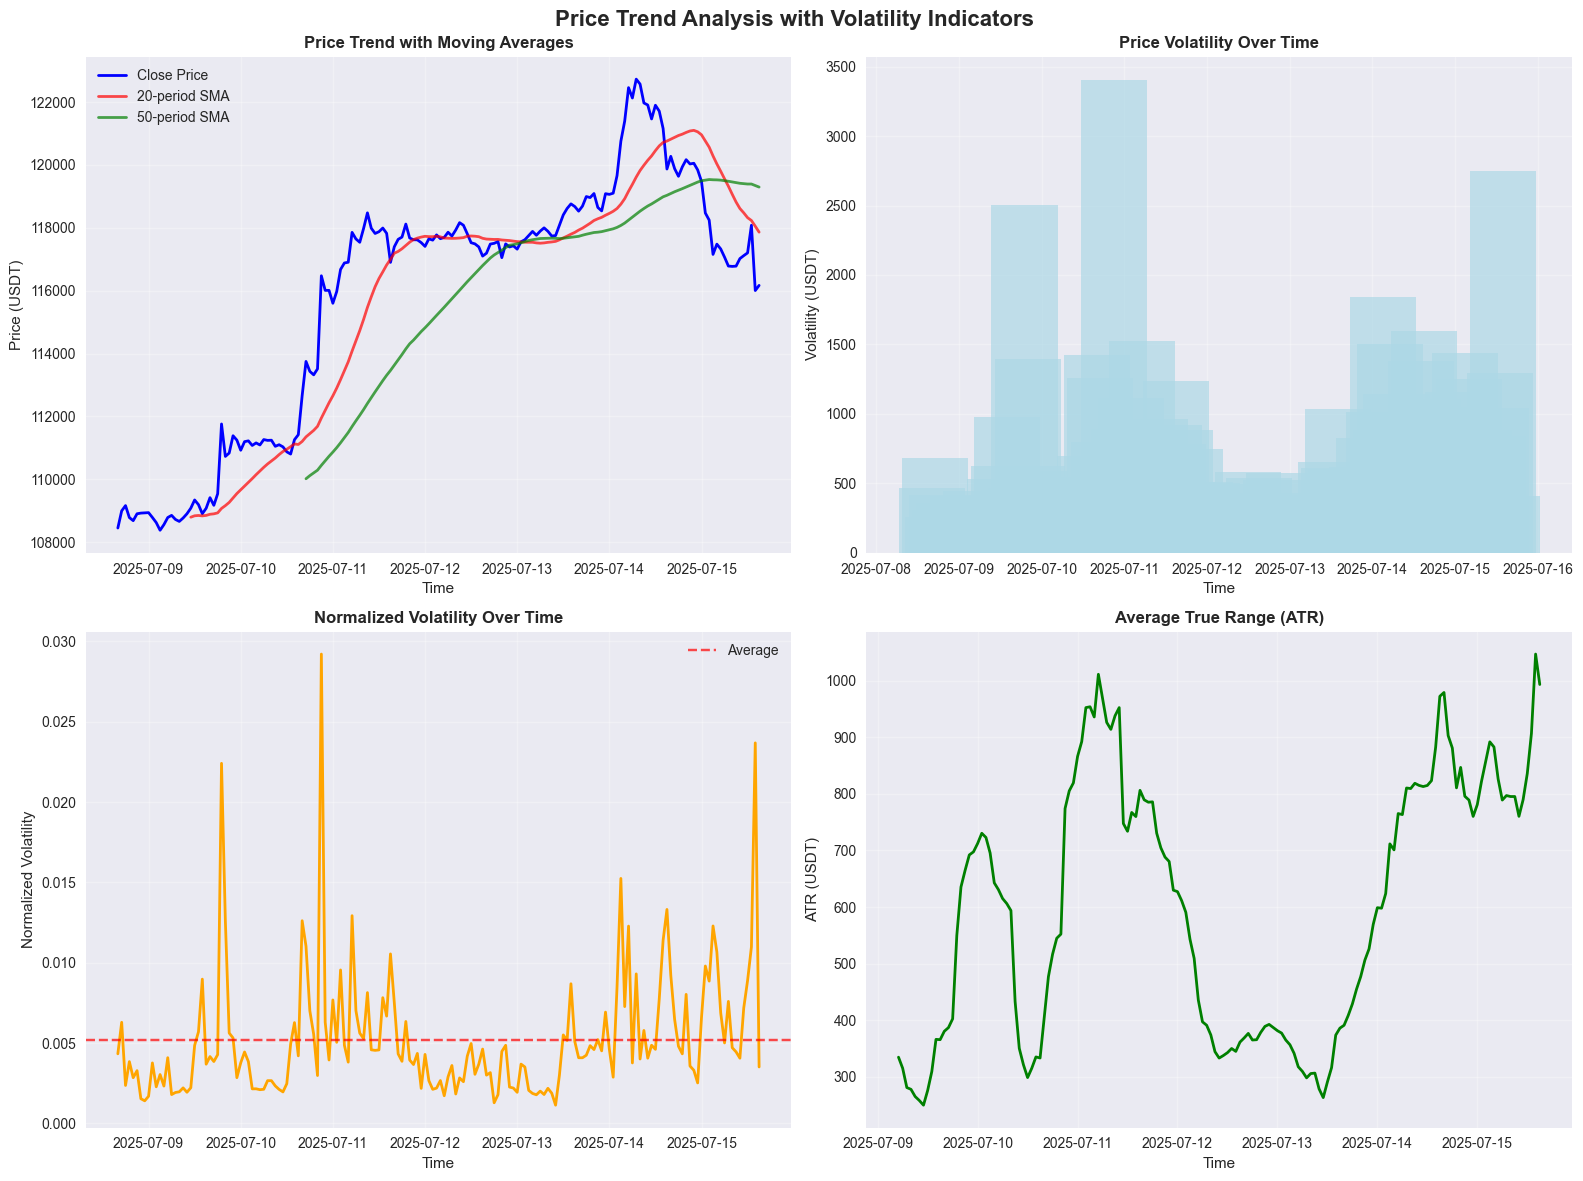

✅ Main visualization complete!


In [7]:
if 'df' in locals() and not df.empty:
    print("🎨 Creating comprehensive visualizations...")
    
    # Create a comprehensive visualization with 4 subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Price Trend Analysis with Volatility Indicators', fontsize=16, fontweight='bold')
    
    # Plot 1: Price with Moving Averages
    ax1.plot(df['time_period_start'], df['close'], label='Close Price', linewidth=2, color='blue')
    ax1.plot(df['time_period_start'], df['sma_20'], label='20-period SMA', linewidth=2, alpha=0.7, color='red')
    ax1.plot(df['time_period_start'], df['sma_50'], label='50-period SMA', linewidth=2, alpha=0.7, color='green')
    ax1.set_title('Price Trend with Moving Averages', fontweight='bold')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price (USDT)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Volatility
    ax2.bar(df['time_period_start'], df['volatility'], alpha=0.7, color='lightblue')
    ax2.set_title('Price Volatility Over Time', fontweight='bold')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Volatility (USDT)')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Normalized Volatility
    ax3.plot(df['time_period_start'], df['normalized_volatility'], color='orange', linewidth=2)
    ax3.axhline(y=df['normalized_volatility'].mean(), color='red', linestyle='--', alpha=0.7, label='Average')
    ax3.set_title('Normalized Volatility Over Time', fontweight='bold')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Normalized Volatility')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: ATR
    ax4.plot(df['time_period_start'], df['atr'], color='green', linewidth=2)
    ax4.set_title('Average True Range (ATR)', fontweight='bold')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('ATR (USDT)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Main visualization complete!")
    
else:
    print("❌ No data available for visualization.")

🎨 Creating trend and volatility correlation plot...


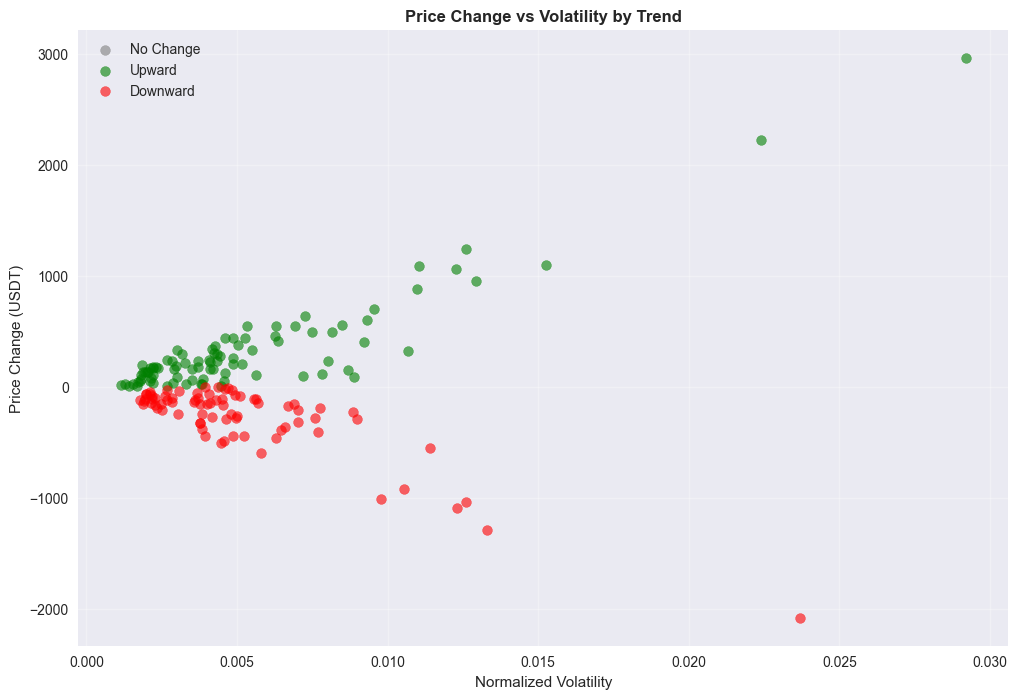

✅ Correlation plot complete!


In [8]:
if 'df' in locals() and not df.empty:
    print("🎨 Creating trend and volatility correlation plot...")
    
    # Create trend and volatility correlation plot
    plt.figure(figsize=(12, 8))
    
    # Color code by trend
    colors = {'Upward': 'green', 'Downward': 'red', 'No Change': 'gray'}
    
    for trend in df['price_trend'].unique():
        mask = df['price_trend'] == trend
        plt.scatter(df[mask]['normalized_volatility'], df[mask]['price_change'], 
                   c=colors[trend], label=trend, alpha=0.6, s=50)
    
    plt.xlabel('Normalized Volatility')
    plt.ylabel('Price Change (USDT)')
    plt.title('Price Change vs Volatility by Trend', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("✅ Correlation plot complete!")
    
else:
    print("❌ No data available for correlation plot.")

## 8. Statistical Analysis and Summary

Let's perform a comprehensive statistical analysis of our findings and provide insights about the price trend and volatility analysis.

In [9]:
if 'df' in locals() and not df.empty:
    print("📊 Performing comprehensive statistical analysis...")
    
    print("=" * 60)
    print("PRICE TREND AND VOLATILITY ANALYSIS SUMMARY")
    print("=" * 60)
    
    print(f"📅 Analysis Period: {df['time_period_start'].min()} to {df['time_period_start'].max()}")
    print(f"📊 Total Data Points: {len(df)}")
    
    print("\n" + "=" * 40)
    print("PRICE STATISTICS")
    print("=" * 40)
    print(f"💰 Starting Price: ${df['close'].iloc[0]:.2f}")
    print(f"💰 Ending Price: ${df['close'].iloc[-1]:.2f}")
    print(f"📈 Total Price Change: ${df['close'].iloc[-1] - df['close'].iloc[0]:.2f}")
    print(f"📊 Percentage Change: {((df['close'].iloc[-1] / df['close'].iloc[0]) - 1) * 100:.2f}%")
    
    print("\n" + "=" * 40)
    print("VOLATILITY STATISTICS")
    print("=" * 40)
    print(f"📊 Average Volatility: {df['volatility'].mean():.4f}")
    print(f"📊 Volatility Range: {df['volatility'].min():.4f} - {df['volatility'].max():.4f}")
    print(f"📊 Average Normalized Volatility: {df['normalized_volatility'].mean():.4f}")
    print(f"📊 Average ATR: {df['atr'].mean():.4f}")
    
    print("\n" + "=" * 40)
    print("TREND ANALYSIS")
    print("=" * 40)
    trend_summary = df['price_trend'].value_counts()
    for trend, count in trend_summary.items():
        percentage = (count / len(df)) * 100
        print(f"📈 {trend} Trend: {count} periods ({percentage:.1f}%)")
    
    print("\n" + "=" * 40)
    print("VOLATILITY REGIME ANALYSIS")
    print("=" * 40)
    volatility_summary = df['volatility_regime'].value_counts()
    for regime, count in volatility_summary.items():
        percentage = (count / len(df)) * 100
        print(f"📊 {regime} Volatility: {count} periods ({percentage:.1f}%)")
    
    # Calculate correlation between price change and volatility
    correlation = df['price_change'].corr(df['normalized_volatility'])
    print("\n" + "=" * 40)
    print("CORRELATION ANALYSIS")
    print("=" * 40)
    print(f"📊 Price Change vs Volatility Correlation: {correlation:.4f}")
    
    if abs(correlation) > 0.3:
        print("🔗 Strong correlation detected between price changes and volatility.")
    elif abs(correlation) > 0.1:
        print("🔗 Moderate correlation detected between price changes and volatility.")
    else:
        print("🔗 Weak correlation between price changes and volatility.")
    
    print("\n" + "=" * 60)
    print("ANALYSIS COMPLETE!")
    print("=" * 60)
    
else:
    print("❌ No data available for summary analysis.")

📊 Performing comprehensive statistical analysis...
PRICE TREND AND VOLATILITY ANALYSIS SUMMARY
📅 Analysis Period: 2025-07-08 16:00:00+00:00 to 2025-07-15 15:00:00+00:00
📊 Total Data Points: 168

PRICE STATISTICS
💰 Starting Price: $108446.61
💰 Ending Price: $116167.57
📈 Total Price Change: $7720.96
📊 Percentage Change: 7.12%

VOLATILITY STATISTICS
📊 Average Volatility: 604.6966
📊 Volatility Range: 133.7623 - 3402.2335
📊 Average Normalized Volatility: 0.0052
📊 Average ATR: 596.5474

TREND ANALYSIS
📈 Upward Trend: 89 periods (53.0%)
📈 Downward Trend: 78 periods (46.4%)
📈 No Change Trend: 1 periods (0.6%)

VOLATILITY REGIME ANALYSIS
📊 Low Volatility: 126 periods (75.0%)
📊 High Volatility: 42 periods (25.0%)

CORRELATION ANALYSIS
📊 Price Change vs Volatility Correlation: 0.2708
🔗 Moderate correlation detected between price changes and volatility.

ANALYSIS COMPLETE!


## 9. Key Insights and Interpretation

Based on our analysis, here are the key insights we can draw:

### 📈 **Price Trend Insights**
- The distribution of upward vs downward trends shows market sentiment
- Moving averages help identify fair value and potential support/resistance levels
- Price changes relative to moving averages indicate buying/selling pressure

### 📊 **Volatility Insights**
- **Normalized Volatility**: Shows relative price movement regardless of absolute price
- **ATR**: Provides a smoothed measure of market volatility
- **Volatility Regimes**: Help identify different market conditions (calm vs turbulent)
- **Volatility Ratio**: Indicates if current volatility is above/below historical average

### 🔗 **Correlation Analysis**
- The correlation between price changes and volatility reveals market dynamics
- Strong positive correlation might indicate momentum-driven markets
- Weak correlation might suggest range-bound or news-driven markets

### 💡 **Trading Implications**
- High volatility periods often present both risk and opportunity
- Trend direction combined with volatility analysis provides better entry/exit signals
- Moving averages can serve as dynamic support/resistance levels
- ATR helps in setting appropriate stop-loss levels

## 10. Next Steps and Customization

### 🔧 **Customization Options**

You can modify this analysis by changing:

- **Trading Pair**: Change `asset_id_base` and `asset_id_quote` (e.g., 'ETH', 'ADA')
- **Time Period**: Modify the `timedelta(days=7)` to analyze different timeframes
- **Interval**: Change `period_id` to '1MIN', '1HRS', '1DAY' for different granularity
- **Indicators**: Add more technical indicators like RSI, MACD, Bollinger Bands

### 📈 **Advanced Analysis Ideas**

1. **Multi-timeframe Analysis**: Compare different time periods
2. **Cross-asset Correlation**: Analyze relationships between different cryptocurrencies
3. **Pattern Recognition**: Implement candlestick pattern detection
4. **Backtesting**: Test trading strategies based on the indicators

## Conclusion

In this tutorial, we successfully:

✅ **Fetched historical exchange rate data** using the CoinAPI Market Data REST API
✅ **Calculated comprehensive volatility indicators** including ATR and normalized volatility
✅ **Detected and analyzed price trends** with statistical rigor
✅ **Created professional visualizations** showing multiple perspectives on the data
✅ **Performed correlation analysis** to understand market dynamics
✅ **Provided actionable insights** for trading and investment decisions

### 🎯 **Key Takeaways**

- **Volatility indicators** help identify periods of high and low market activity
- **Price trends combined with volatility analysis** provide better trading insights
- **ATR (Average True Range)** is a robust measure of market volatility
- **Moving averages** serve as dynamic trend indicators
- **Volatility regimes** help identify different market conditions

This tutorial demonstrates how to use the CoinAPI Market Data REST API for advanced price trend and volatility analysis, providing a solid foundation for cryptocurrency market analysis and trading strategy development.

---

**Happy analyzing! 📈📊**